 # 🔧 Fine-tuned Model ⚙️ 

In [2]:
# from pathlib import Path
import pandas as pd, numpy as np
from osgeo import gdal
from pathlib import Path
import geopandas as gpd
import rioxarray as rxr
import rasterio
import holoviews as hv
import hvplot.pandas
hv.extension("plotly")

import samgeo
import os
import torch
import leafmap
from samgeo import tms_to_geotiff
from bldg_sam import BldgSAM

g = 'geometry'

In [3]:
extents = 'Extents.shp'

In [4]:
AOI = gpd.read_file(extents)
AOI4plot = AOI.to_crs(epsg=3857)
AOI4plot['geometry'] = AOI4plot.boundary
AOI4plot.hvplot(
   tiles='ESRI',
   line_color='red',
   line_width=6,
   width=1280,height=800,
   padding=0,
   title='<b>Area of Interest</b>'
   )

:Overlay
   .Tiles.I :Tiles   [x,y]
   .Path.I  :Path   [x,y]

 # 🏞️ Gather Imagery ⛰️
You may opt to supply your own TIF file here; for this demo we will downlod it based on the AOI extents

In [88]:
 # Take bounding box of area of interest in WGS 84 coordinates
bbox = list(AOI.to_crs(epsg=4326).total_bounds)
bbox

[4.939526581775804, 52.361658238103225, 4.9446372738869115, 52.363835014372775]

In [5]:
image = 'satellite2.tif'
# image = f"{extents.split('.')[0]}.tif"
image

'satellite2.tif'

In [90]:
tms_to_geotiff(output=str(image), bbox=bbox, zoom=19, source='Satellite')

Downloaded image 01/54
Downloaded image 02/54
Downloaded image 03/54
Downloaded image 04/54
Downloaded image 05/54
Downloaded image 06/54
Downloaded image 07/54
Downloaded image 08/54
Downloaded image 09/54
Downloaded image 10/54
Downloaded image 11/54
Downloaded image 12/54
Downloaded image 13/54
Downloaded image 14/54
Downloaded image 15/54
Downloaded image 16/54
Downloaded image 17/54
Downloaded image 18/54
Downloaded image 19/54
Downloaded image 20/54
Downloaded image 21/54
Downloaded image 22/54
Downloaded image 23/54
Downloaded image 24/54
Downloaded image 25/54
Downloaded image 26/54
Downloaded image 27/54
Downloaded image 28/54
Downloaded image 29/54
Downloaded image 30/54
Downloaded image 31/54
Downloaded image 32/54
Downloaded image 33/54
Downloaded image 34/54
Downloaded image 35/54
Downloaded image 36/54
Downloaded image 37/54
Downloaded image 38/54
Downloaded image 39/54
Downloaded image 40/54
Downloaded image 41/54
Downloaded image 42/54
Downloaded image 43/54
Downloaded 

 #  Automatic Segmentation with Custom Fine-Tuned Model 🧠➜🤖

In [6]:
sam = BldgSAM()

Using building detector checkpoint c:\Users\seanm\Docs\SegmentAnything\best.pt


In [7]:
 # If you have an NVIDIA GPU and have set up CUDA correctly, this will return 'cuda'
 # If not, this link should provide you the correct install command for your platform
#  https://pytorch.org/get-started/locally/
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
 # Load the TIF image file and run inference
# image = 'satellite19.tif'
sam.predict(image, 
    box_threshold=0,
    )


0: 256x256 5 buildings, 13.5ms
Speed: 4.1ms preprocess, 13.5ms inference, 343.8ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 7 buildings, 13.4ms
Speed: 0.4ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 8 buildings, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 10 buildings, 13.0ms
Speed: 0.0ms preprocess, 13.0ms inference, 3.0ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 8 buildings, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 17.0ms postprocess per image at shape (1, 3, 256, 256)

0: 256x192 6 buildings, 143.7ms
Speed: 1.0ms preprocess, 143.7ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 192)

0: 256x256 9 buildings, 14.0ms
Speed: 2.0ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 9 buildings, 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 2.0ms postproces

Postprocessing detections...
done


`box_threshold`: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

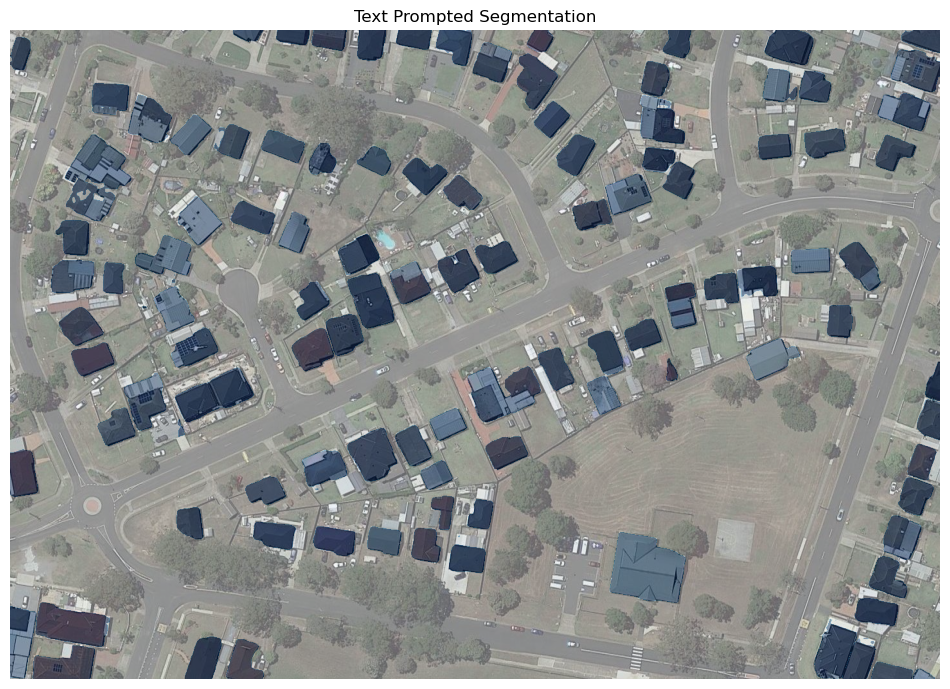

In [9]:
sam.show_anns(
    cmap='Blues',
    add_boxes=False,
    box_color='red',
    title='Text Prompted Segmentation',
    blend=True,
)

In [14]:
outTIF = 'sydney-bldgs.tif'
sam.show_anns(
    cmap='Greys_r',
    add_boxes=False,
    alpha=1,
    title=f'Saved to {outTIF}',
    blend=False,
    output=outTIF,
)

In [7]:
vector = 'Sydney-BLDGs.gpkg'
sam.raster_to_vector(outTIF, vector)

NameError: name 'outTIF' is not defined

In [13]:
bldgs = gpd.read_file(vector)
bldgs.plot()

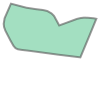

In [13]:
 # Here we extract only the segmented buildings in our Area of Interest
 # This technique of looking at a larger image to give us better context helps avoid 
bldgs = bldgs.to_crs(AOI.crs)
AOIpoly = AOI.dissolve().loc[0,g]
AOIpoly

In [15]:
# Subset to only the buildings which intersect our area of interest
# If needed, please review geopandas, pandas, and shapely documentation on how this works
bldgs = bldgs[ bldgs[g].intersects(AOIpoly) ]
bldgs.plot()

In [15]:
bldgs.to_file(vector)
print(f'Building footprints exported to {vector}')

Building footprints exported to Sydney-BLDGs.gpkg
